### Домашнее задание 3
* Обучить AE собственной архитектуры на MNIST
* Обучить VAE собственной архитектуры на MNIST
* *Обучить VAE с переносом стиля на MNIST (на вход декодеру подавать hidden c таргетным значением, чтобы можно было нарисовать заданную цифру в заданном стиле)

## AE собственной архитектуры
Получилось применить MaxPool2d в Endocder & MaxUnpool2d в Decoder

In [485]:
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [486]:
dataset = datasets.MNIST('.', download=True)

In [487]:
# hyperparams
in_chan = 1
hidden_ch = 64
out_ch = 1
device_id = -1
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 10
batch_size = 128

In [488]:
class Encoder(nn.Module):


  def __init__(self, in_chan, hidden_ch, out_ch):
    super().__init__()
    self.conv1 = nn.Conv2d(in_chan, hidden_ch, kernel_size=5, padding=2, stride=2)
    self.activation = nn.ReLU()
    self.polling = nn.MaxPool2d(kernel_size=3, padding=1, stride=1, return_indices=True)
    self.conv2 = nn.Conv2d(hidden_ch, out_ch, kernel_size=3, padding=1, stride=1)

    
  def forward(self, x):
    x = self.conv1(x)
    x = self.activation(x)
    x_tuple = self.polling(x)
    x = x_tuple[0]
    x_indices = x_tuple[1]
    x = self.conv2(x)
    return (x, x_indices)

class Decoder(nn.Module):
  #hidden_out-> hidden -> 28*28
  def __init__(self, in_chan, hidden_ch, out_ch):
    super().__init__()
    self.conv1 = nn.Conv2d(in_chan, hidden_ch, kernel_size=3, stride=1, padding=1) # обратная операция для self.conv1 из Encoder
    self.activ = nn.ReLU()
    self.unpool = nn.MaxUnpool2d(kernel_size=3, padding=1, stride=1)
    self.upsample2 = nn.UpsamplingNearest2d(scale_factor=2) # 28 x 28
    self.conv2 = nn.Conv2d(hidden_ch, out_ch, kernel_size=5, stride=2, padding=2)
    
  def forward(self, x, ind):
    x = self.conv1(x)
    
    x = self.unpool(x,ind)
    x = self.upsample2(x)
    x = self.activ(x)
    x = self.conv2(x)
    x = self.upsample2(x)
    return x

class ConvAutoEncoder(nn.Module):
  def __init__(self, in_chan, hidden_ch, out_ch):
    super().__init__()
    self.encoder = Encoder(in_chan, hidden_ch, out_ch)
    self.decoder = Decoder(in_chan, hidden_ch, out_ch)

  def forward(self, x):
    hidden_tupple = self.encoder(x)
    x_ = self.decoder(hidden_tupple[0], hidden_tupple[1])
    return x_

In [489]:
def collate_fn_conv(data: list):
  # data = [(pic, target)...]
  pics = []
  target = []
  for item in data:
    pics.append(numpy.array(item[0]))
    target.append(item[1])
  pics = torch.from_numpy(numpy.array(pics)).float() / 255 # B x W x H
  target = torch.from_numpy(numpy.array(target))

  return {
      'data': pics.unsqueeze(1), # B x 1 x W x H
      'target': target.long(),
      }

In [490]:
model_conv = ConvAutoEncoder(in_chan, hidden_ch, out_ch).to(device)
optim = torch.optim.Adam(model_conv.parameters())
loss_func = nn.L1Loss()

epoch: 0, step: 0, loss: 0.17139562964439392
epoch: 0, step: 200, loss: 0.06414800137281418
epoch: 0, step: 400, loss: 0.06518000364303589


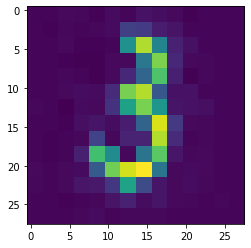

epoch: 1, step: 0, loss: 0.06467457860708237
epoch: 1, step: 200, loss: 0.06363438814878464
epoch: 1, step: 400, loss: 0.060502588748931885


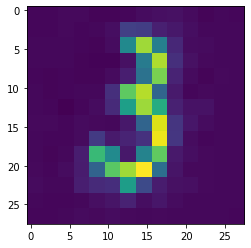

epoch: 2, step: 0, loss: 0.07016291469335556
epoch: 2, step: 200, loss: 0.06791585683822632
epoch: 2, step: 400, loss: 0.06236584484577179


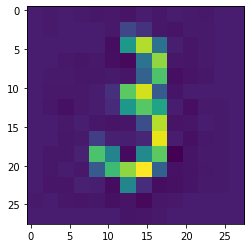

epoch: 3, step: 0, loss: 0.06594683974981308
epoch: 3, step: 200, loss: 0.06053972244262695
epoch: 3, step: 400, loss: 0.06561289727687836


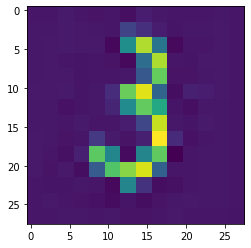

epoch: 4, step: 0, loss: 0.06269636750221252
epoch: 4, step: 200, loss: 0.06144297868013382
epoch: 4, step: 400, loss: 0.06289662420749664


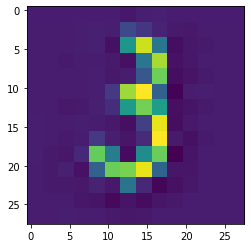

epoch: 5, step: 0, loss: 0.06616952270269394
epoch: 5, step: 200, loss: 0.06101521849632263
epoch: 5, step: 400, loss: 0.06231042370200157


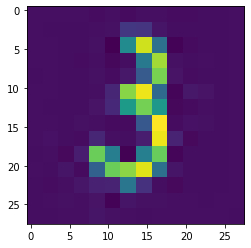

epoch: 6, step: 0, loss: 0.05894839018583298
epoch: 6, step: 200, loss: 0.05770896375179291
epoch: 6, step: 400, loss: 0.060847945511341095


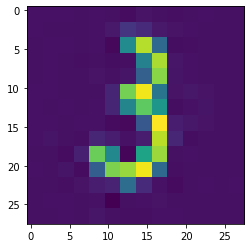

epoch: 7, step: 0, loss: 0.06059613078832626
epoch: 7, step: 200, loss: 0.06017505005002022
epoch: 7, step: 400, loss: 0.05714184790849686


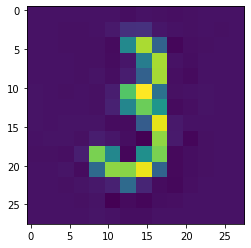

epoch: 8, step: 0, loss: 0.05951021984219551
epoch: 8, step: 200, loss: 0.05949309840798378
epoch: 8, step: 400, loss: 0.06317874044179916


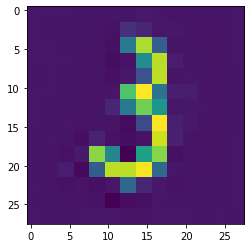

epoch: 9, step: 0, loss: 0.05932928994297981
epoch: 9, step: 200, loss: 0.05731234699487686
epoch: 9, step: 400, loss: 0.0620039738714695


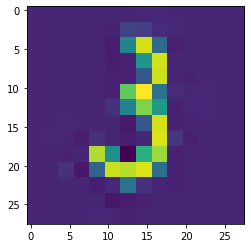

In [491]:
for epoch in range(n_epochs):
  dataloader = DataLoader(dataset,
                          batch_size,
                          shuffle=True,
                          collate_fn=collate_fn_conv,
                          drop_last = True,
                          )
  for i, batch in enumerate(dataloader):
    optim.zero_grad()

    predict = model_conv(batch['data'].to(device))
    loss = loss_func(predict, batch['data'].to(device))
    loss.backward()
    optim.step()
    if i % 200 == 0:
      print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
  item = dataset.data[1234].unsqueeze(0).unsqueeze(0).float()/255
  plt.imshow(model_conv(item.to(device)).squeeze().cpu().detach().numpy())
  plt.show()

## VAE собственной архитектуры

In [492]:
# hyperparams
in_chan = 1
hidden_ch = 100
out_ch = 1
device_id = -1
device = 'mps' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 10
batch_size = 128

In [493]:
class EncoderVAE(nn.Module):
  #28*28 -> hidden -> hidden_out
  def __init__(self, input_ch, hidden_ch):
    super().__init__()
    # меньше слоев: сворачиваю картинку сразу в 4 раза.
    self.conv1 = nn.Conv2d(input_ch, hidden_ch, kernel_size=5, stride=1, 
                           padding=2) # 28x28
    self.do1 = nn.Dropout(0.1)
    self.pool1 = nn.MaxPool2d(4, 4) # 7x7
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 7x7

    self.conv3_mu = nn.Conv2d(hidden_ch, 1, kernel_size=3, stride=1, padding=1) # 7x7
    self.conv3_sigma = nn.Conv2d(hidden_ch, 1, kernel_size=3, stride=1, 
                           padding=1) # 7x7
    self.activ = nn.ReLU()

  def forward(self, x):
    x = self.pool1(self.do1(self.activ(self.conv1(x))))
    mu = self.conv3_mu(x)
    sigma = torch.exp(self.conv3_sigma(x))

    return mu, sigma


class DecoderVAE(nn.Module):
#hidden_out-> hidden -> 28*28 
  def __init__(self, input_ch, hidden_ch, ):
    super().__init__()
    self.conv1 = nn.Conv2d(1, hidden_ch, kernel_size=3, stride=1, padding=1) # 7x7
    self.do1 = nn.Dropout(0.1)
    self.upsample1 = nn.UpsamplingNearest2d(scale_factor=4) # 28x28
    self.conv3 = nn.Conv2d(hidden_ch, input_ch, kernel_size=5, stride=1, 
                           padding=2) # 28x28
    self.activ = nn.ReLU()
  def forward(self, x):
    x = self.conv1(x)
    x = self.activ(x)
    x = self.do1(x)
    x = self.upsample1(x)
    x = self.conv3(x)
    return x


def sampling(mu, sigma):
  norm = torch.normal(torch.zeros_like(sigma), torch.ones_like(sigma))
  return mu + sigma * norm

class ConvVarAutoEncoder(nn.Module):
  def __init__(self, in_chan, hidden_ch, out_ch):
    super().__init__()
    self.encoder = EncoderVAE(in_chan, hidden_ch)
    self.decoder = DecoderVAE(in_chan, hidden_ch)

  def forward(self, x):

    mu, sigma = self.encoder(x)
    hidden = sampling(mu, sigma)
    x_ = self.decoder(hidden)
    return x_, mu, sigma

In [494]:
model_conv_vae = ConvVarAutoEncoder(in_chan, hidden_ch, out_ch).to(device)
optim_vae = torch.optim.Adam(model_conv_vae.parameters())
loss_func_vae = nn.MSELoss()

def kl_loss(mu, sigma):
    p = torch.distributions.Normal(mu, sigma)
    q = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(sigma))

    return torch.distributions.kl_divergence(p, q).mean()

epoch: 0, step: 0, loss: 0.016113944351673126
epoch: 0, step: 200, loss: 0.016109123826026917
epoch: 0, step: 400, loss: 0.016285685822367668


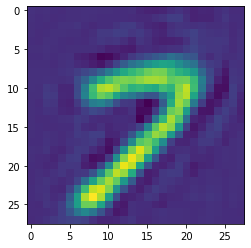

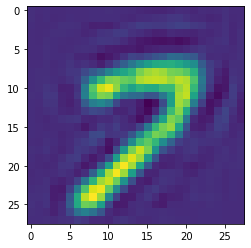

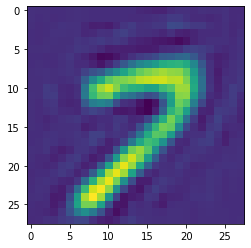

epoch: 1, step: 0, loss: 0.016079366207122803
epoch: 1, step: 200, loss: 0.016081832349300385
epoch: 1, step: 400, loss: 0.015238654799759388


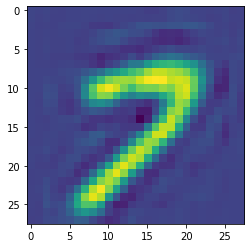

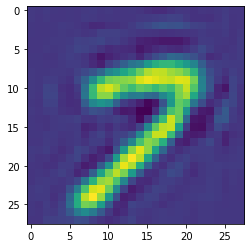

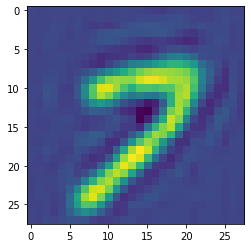

epoch: 2, step: 0, loss: 0.015995198860764503
epoch: 2, step: 200, loss: 0.015845589339733124
epoch: 2, step: 400, loss: 0.015128947794437408


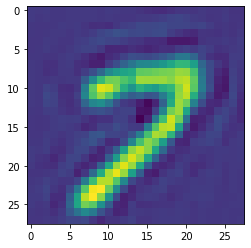

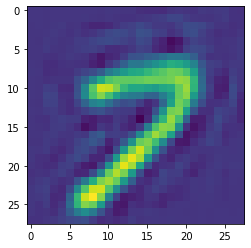

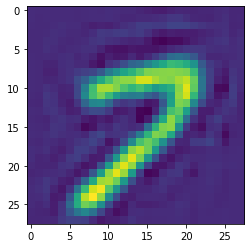

epoch: 3, step: 0, loss: 0.01546903233975172
epoch: 3, step: 200, loss: 0.016610924154520035
epoch: 3, step: 400, loss: 0.01622345857322216


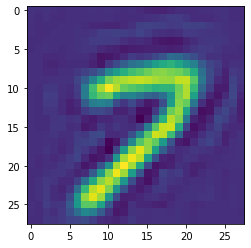

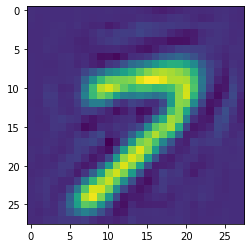

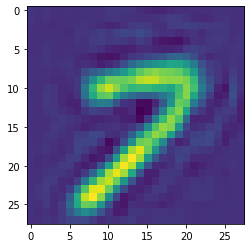

epoch: 4, step: 0, loss: 0.015343597158789635
epoch: 4, step: 200, loss: 0.015225614421069622
epoch: 4, step: 400, loss: 0.015714649111032486


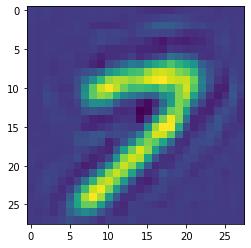

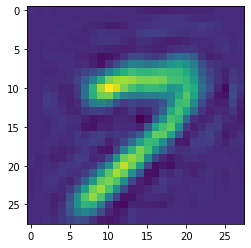

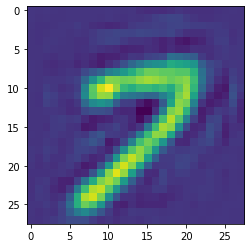

epoch: 5, step: 0, loss: 0.016490302979946136
epoch: 5, step: 200, loss: 0.015669433400034904
epoch: 5, step: 400, loss: 0.015490819700062275


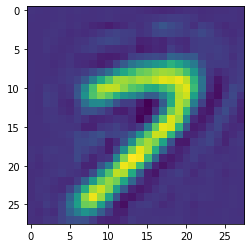

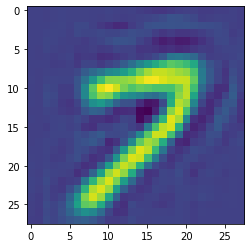

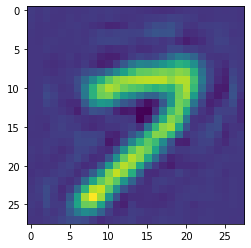

epoch: 6, step: 0, loss: 0.015493999235332012
epoch: 6, step: 200, loss: 0.015240157954394817
epoch: 6, step: 400, loss: 0.01651611365377903


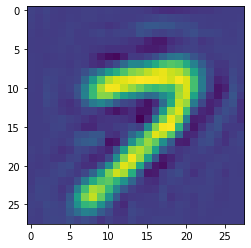

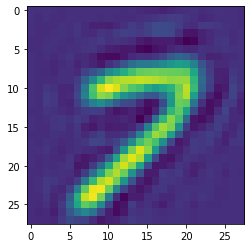

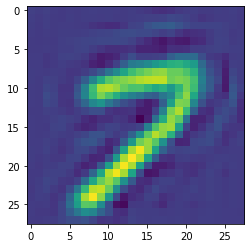

epoch: 7, step: 0, loss: 0.01630067266523838
epoch: 7, step: 200, loss: 0.015107851475477219
epoch: 7, step: 400, loss: 0.015646062791347504


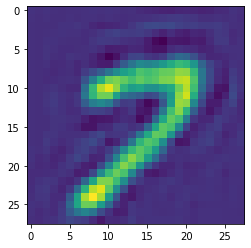

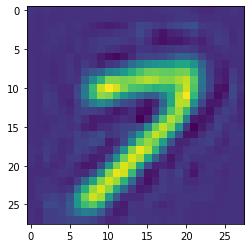

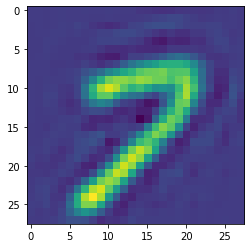

epoch: 8, step: 0, loss: 0.0166160948574543
epoch: 8, step: 200, loss: 0.016025040298700333
epoch: 8, step: 400, loss: 0.015804044902324677


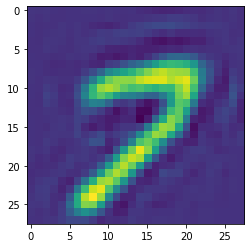

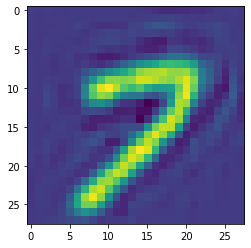

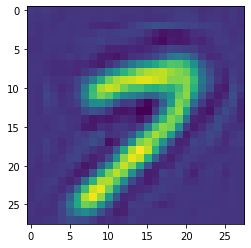

epoch: 9, step: 0, loss: 0.015287171117961407
epoch: 9, step: 200, loss: 0.015940340235829353
epoch: 9, step: 400, loss: 0.015075918287038803


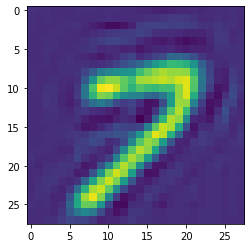

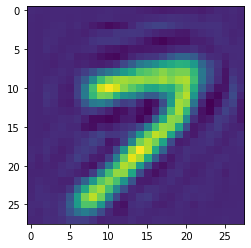

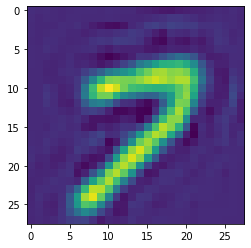

In [503]:
for epoch in range(n_epochs):
  dataloader = DataLoader(dataset, 
                          batch_size, 
                          shuffle=True, 
                          collate_fn=collate_fn_conv,
                          drop_last = True,
                          )
  for i, batch in enumerate(dataloader):
    optim_vae.zero_grad()
    data = batch['data'].to(device)

    predict, mu, sigma = model_conv_vae(data)
    loss = loss_func_vae(predict, data) + 0.0001 * kl_loss(mu, sigma)
    loss.backward()
    optim_vae.step()
    if i % 200 == 0:
      print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
  item = dataset.data[911].unsqueeze(0).unsqueeze(0).float()/255
  mu, sigma = model_conv_vae.encoder(item.to(device))
  item = torch.normal(torch.zeros((1,1,7,7)), 3 * torch.ones((1,1,7,7)))
  for i in range(3):
    plt.imshow(model_conv_vae.decoder(sampling(mu, sigma))[0].squeeze().cpu().detach().numpy())
    plt.show()